In [1]:
from pathlib import Path
import re
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from lumicks import pylake
import seaborn as sns

Loading file /Users/sylvi/optical_data/loading_markers/data/20250611-124102 Tel5 1nM Trf2dTRFH Marker 1.h5
<class 'lumicks.pylake.file.File'>
curve ids: dict_keys(['10', '11', '12', '13', '14', '4', '5', '6', '7', '8', '9'])
Curve ID: 11


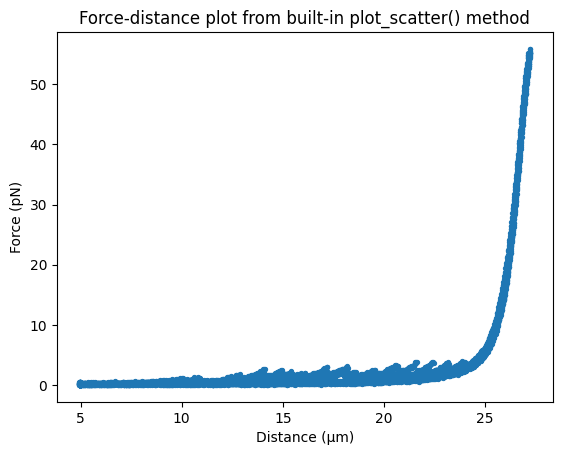

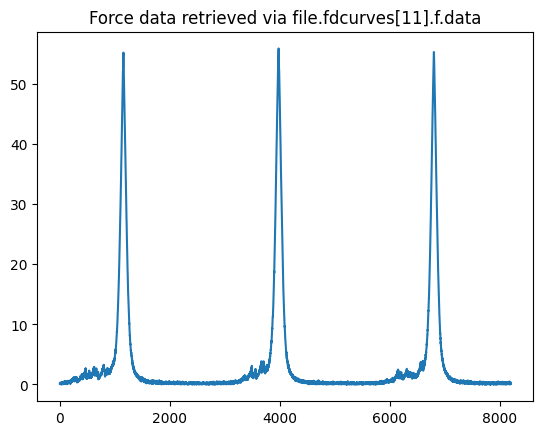

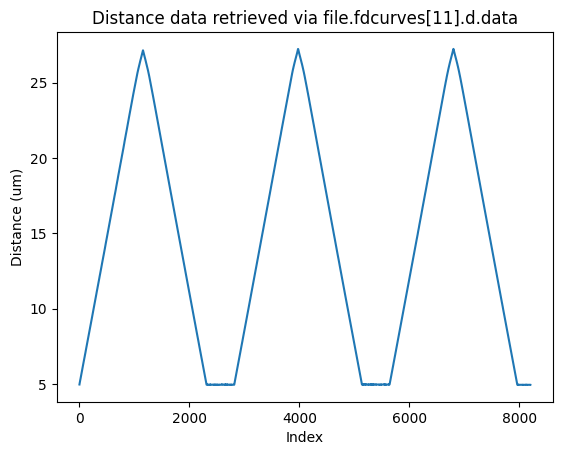

First distance: 4.969424332352072 um


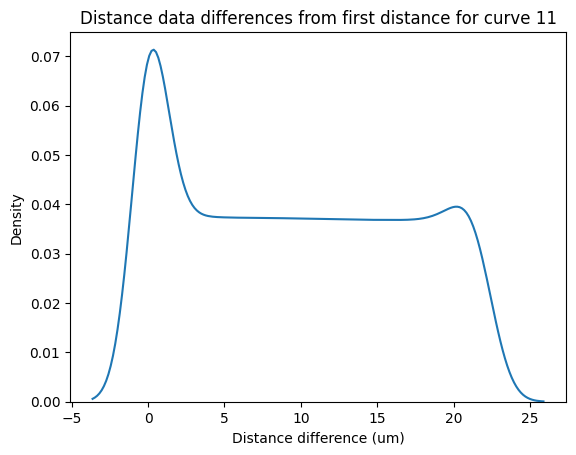

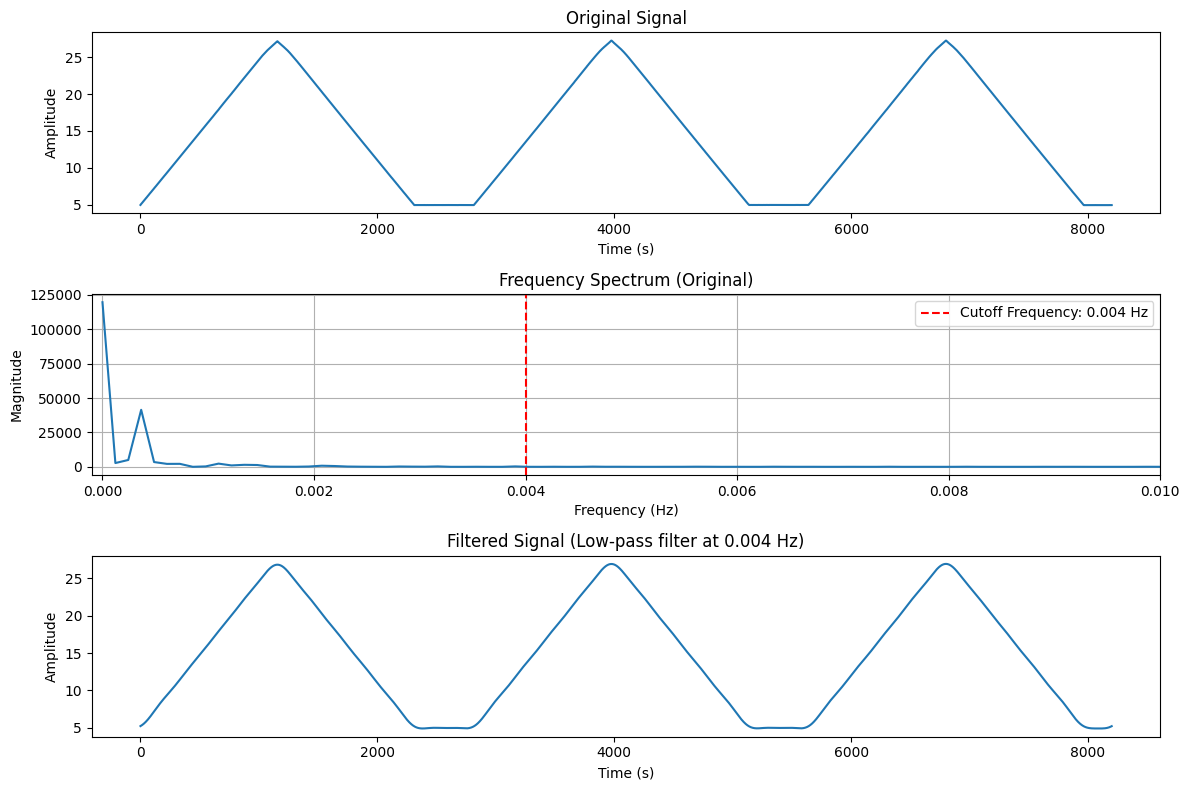

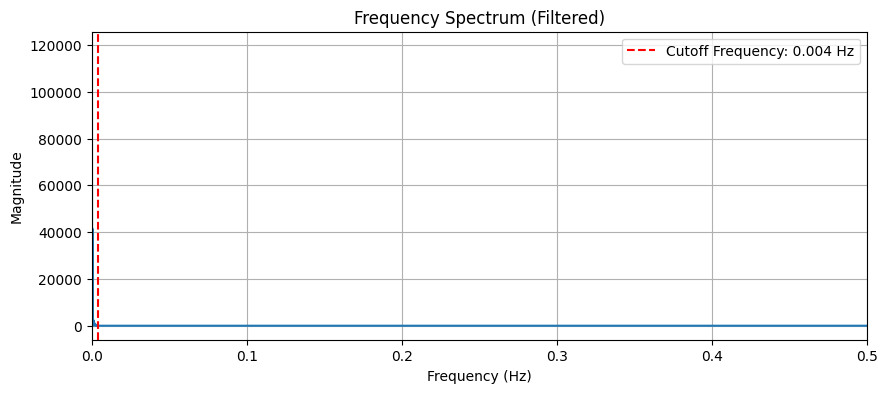

In [ ]:
data_dirs = [Path("/Users/sylvi/optical_data/loading_markers/data")]

for data_dir in data_dirs:
    assert data_dir.exists(), f"Data directory {data_dir} does not exist."

output_folder = Path("/Users/sylvi/optical_data/loading_markers/processed/")

markers = {}

for data_dir in data_dirs:
    for file in data_dir.glob("*.h5"):
        if file.is_file() and "Marker" in file.name:
            print(f"Loading file {file}")
            marker_data = pylake.File(file)
            print(type(marker_data))

            # get metadata from the file name
            tel_reps = re.search(r"Tel(\d+)", file.name)
            if tel_reps:
                tel_reps = int(tel_reps.group(1))
            else:
                raise ValueError(f"Could not find telereps in file name {file.name}")

            protein_name = re.search(r" (\w+)(?= Marker \d+)", file.name)
            if protein_name:
                protein_name = protein_name.group(1)
            else:
                raise ValueError(f"Could not find protein name in file name {file.name}")

            # extract the curves
            print(f"curve ids: {marker_data.fdcurves.keys()}")

            for curve_id, curve_data in marker_data.fdcurves.items():

                if curve_id != "11":
                    continue

                print(f"Curve ID: {curve_id}")
                force_data = curve_data.f.data
                curve_data.plot_scatter()
                plt.title(f"Force-distance plot from built-in plot_scatter() method")
                plt.show()
                print(curve_data.f)
                plt.plot(force_data)
                plt.title(f"Force data retrieved via file.fdcurves[{curve_id}].f.data")
                plt.show()

                distance_data = curve_data.d.data

                plt.plot(distance_data)
                plt.title(f"Distance data retrieved via file.fdcurves[{curve_id}].d.data")
                plt.xlabel("Index")
                plt.ylabel("Distance (um)")
                plt.show()

                first_distance = distance_data[0]
                print(f"First distance: {first_distance} um")
                first_distance_differences = distance_data - first_distance
                sns.kdeplot(first_distance_differences)
                plt.title(f"Distance data differences from first distance for curve {curve_id}")
                plt.xlabel("Distance difference (um)")
                plt.ylabel("Density")
                plt.show()

                t = np.arange(len(distance_data))  # create a time vector based on the length of the distance data

                # find fft
                fft_signal = np.fft.fft(distance_data)

                # create frequency axis
                sampling_rate = 1  # assume unit rate for this data, doesn't matter i don't think
                num_samples = len(distance_data)
                fft_freq = np.fft.fftfreq(num_samples, 1 / sampling_rate)

                # identify and Filter Frequencies
                # Define the cutoff frequency
                cutoff_frequency = 0.004

                # create a mask to zero out frequencies above the cutoff
                # need to filter both positive and negative frequencies
                fft_mask = np.abs(fft_freq) > cutoff_frequency

                # Apply the mask: set the corresponding FFT amplitudes to zero
                filtered_fft_signal = fft_signal.copy()
                filtered_fft_signal[fft_mask] = 0

                # inverse FFT
                filtered_signal = np.fft.ifft(filtered_fft_signal)

                # only use real part
                filtered_signal = np.real(filtered_signal)

                plt.figure(figsize=(12, 8))
                # plot original signal
                plt.subplot(3, 1, 1)
                plt.title("Original Signal")
                plt.plot(t, distance_data)
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")

                # plot magnitude of the original FFT
                plt.subplot(3, 1, 2)
                plt.title("Frequency Spectrum (Original)")
                # plot only positive frequencies for clarity
                positive_freq_indices = np.where(fft_freq >= 0)
                plt.plot(fft_freq[positive_freq_indices], np.abs(fft_signal[positive_freq_indices]))
                plt.axvline(
                    x=cutoff_frequency, color="r", linestyle="--", label=f"Cutoff Frequency: {cutoff_frequency} Hz"
                )
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Magnitude")
                plt.legend()
                plt.grid(True)
                # plt.xlim(0, sampling_rate/2) # Show up to the Nyquist frequency
                plt.xlim(-0.0001, 0.01)

                # plot filtered signal
                plt.subplot(3, 1, 3)
                plt.title(f"Filtered Signal (Low-pass filter at {cutoff_frequency} Hz)")
                plt.plot(t, filtered_signal)
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")

                plt.tight_layout()
                plt.show()

                # plot filtered spectrum
                plt.figure(figsize=(10, 4))
                plt.title("Frequency Spectrum (Filtered)")
                plt.plot(fft_freq[positive_freq_indices], np.abs(filtered_fft_signal[positive_freq_indices]))
                plt.axvline(
                    x=cutoff_frequency, color="r", linestyle="--", label=f"Cutoff Frequency: {cutoff_frequency} Hz"
                )
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Magnitude")
                plt.legend()
                plt.grid(True)
                plt.xlim(0, sampling_rate / 2)
                plt.show()

                # plt.plot(distance_data)
                # plt.title(f"Distance data retrieved via file.fdcurves[{curve_id}].d.data")
                # plt.show()

                # plt.plot(distance_data, force_data)
                # plt.title(f"Force vs Distance for curve {curve_id}")
                # plt.xlabel("Distance (um)")
                # plt.ylabel("Force (pN)")
                # plt.show()

                # plt.scatter(distance_data, force_data, s=8)
                # plt.title(f"Force vs Distance Scatter for curve {curve_id}")
                # plt.xlabel("Distance (um)")
                # plt.ylabel("Force (pN)")
                # plt.show()

                # distance_diffs = np.diff(distance_data)
                # plt.plot(distance_diffs)
                # plt.title(f"Distance differences for curve {curve_id}")
                # plt.xlabel("Index")
                # plt.ylabel("Distance difference (um)")
                # plt.show()

                # distance_diff_direction_threshold = 0.02
                # distance_increasing = distance_diffs > distance_diff_direction_threshold
                # distance_decreasing = distance_diffs < -distance_diff_direction_threshold
                # distance_stable = np.abs(distance_diffs) <= distance_diff_direction_threshold
                # distance_state = np.zeros_like(distance_diffs)
                # distance_state[distance_increasing] = 1
                # distance_state[distance_decreasing] = -1
                # plt.scatter(range(len(distance_state)), distance_state, s=8)
                # plt.title(f"Distance state for curve {curve_id}")
                # plt.xlabel("Index")
                # plt.ylabel("State (1: increasing, -1: decreasing, 0: stable)")
                # plt.show()

                # oscillations = []
                # current_oscillations = {
                #     "increasing": {
                #         "force": None,
                #         "distance": None,
                #     },
                #     "decreasing": {
                #         "force": None,
                #         "distance": None,
                #     },
                #     "stable": {
                #         "force": None,
                #         "distance": None,
                #     },
                # }
                # previous_stop_index = 0
                # current_state = distance_state[0]
                # assert current_state == 1, "Initial state should be increasing"

                # for new_index, new_state in enumerate(distance_state):
                #     if new_state == current_state:
                #         continue
                #     else:
                #         print(f"new state: {new_state}, current state: {current_state}, new index: {new_index}")
                #         # end of current state, add array segment, inclusive of start and exclusive of end
                #         current_segment_force = force_data[previous_stop_index:new_index]
                #         current_segment_distance = distance_data[previous_stop_index:new_index]
                #         if new_state == 1:
                #             # started a new increasing segment, so save the previous oscillation and reset
                #             assert current_state == 0, "Current state should be stable before increasing"
                #             current_oscillations["stable"]["force"] = current_segment_force
                #             current_oscillations["stable"]["distance"] = current_segment_distance
                #             current_state = new_state
                #             previous_stop_index = new_index
                #             # after a stable segment, we append this oscillation to the list and reset
                #             # check each force and distance array are not None
                #             if (
                #                 current_oscillations["increasing"]["force"] is None
                #                 or current_oscillations["increasing"]["distance"] is None
                #                 or current_oscillations["decreasing"]["force"] is None
                #                 or current_oscillations["decreasing"]["distance"] is None
                #                 or current_oscillations["stable"]["force"] is None
                #                 or current_oscillations["stable"]["distance"] is None
                #             ):
                #                 raise ValueError("One of the oscillation segments is None")
                #             oscillations.append(current_oscillations)
                #             current_oscillations = {
                #                 "increasing": {
                #                     "force": None,
                #                     "distance": None,
                #                 },
                #                 "decreasing": {
                #                     "force": None,
                #                     "distance": None,
                #                 },
                #                 "stable": {
                #                     "force": None,
                #                     "distance": None,
                #                 },
                #             }
                #         elif new_state == -1:
                #             # started a new decreasing segment
                #             assert current_state == 1, "Current state should be increasing before decreasing"
                #             current_oscillations["increasing"]["force"] = current_segment_force
                #             current_oscillations["increasing"]["distance"] = current_segment_distance
                #             current_state = new_state
                #             previous_stop_index = new_index
                #         elif new_state == 0:
                #             # started a new stable segment
                #             if current_state == 1:
                #                 # this could be where we have reached the peak and are waiting for a decrease.
                #                 # ignore and continue
                #                 continue
                #             else:
                #                 current_oscillations["decreasing"]["force"] = current_segment_force
                #                 current_oscillations["decreasing"]["distance"] = current_segment_distance
                #                 previous_stop_index = new_index
                #                 current_state = new_state
                #         else:
                #             raise ValueError(f"Unexpected state value: {new_state}")
                # # handle the last segment
                # # check if the last segment is stable
                # if current_state == 0:
                #     current_segment_force = force_data[previous_stop_index : new_index + 1]
                #     current_segment_distance = distance_data[previous_stop_index : new_index + 1]
                #     current_oscillations["stable"]["force"] = current_segment_force
                #     current_oscillations["stable"]["distance"] = current_segment_distance
                #     oscillations.append(current_oscillations)
                # else:
                #     raise ValueError(f"Last segment is not stable, state: {current_state}")

                # # iterate over the oscillations and plot them and fit the return curve
                # for oscillation_index, oscillation in enumerate(oscillations):
                #     # plot the decreasing segment
                #     decreasing_force = oscillation["decreasing"]["force"]
                #     decreasing_distance = oscillation["decreasing"]["distance"]

                #     plt.plot(decreasing_distance, decreasing_force, label="Decreasing Segment")
                #     plt.title(f"Decreasing segment of oscillation {oscillation_index} for curve {curve_id}")
                #     plt.xlabel("Distance (um)")
                #     plt.ylabel("Force (pN)")
                #     plt.legend()
                #     plt.show()

                #     # fit a ewlc model to it
                #     model = pylake.ewlc_odijk_force(name="ewlc_return_fit") + pylake.force_offset(
                #         name="ewlc_return_fit"
                #     )
                #     fit = pylake.FdFit(model)
                #     fit.add_data(name="return", f=decreasing_force, d=decreasing_distance)
                #     fit["ewlc_return_fit/Lp"].value = 50
                #     fit["ewlc_return_fit/Lp"].lower_bound = 39
                #     fit["ewlc_return_fit/Lp"].upper_bound = 80
                #     fit["ewlc_return_fit/Lc"].value = 27
                #     fit["ewlc_return_fit/f_offset"].lower_bound = 0
                #     fit["ewlc_return_fit/f_offset"].upper_bound = 1

                #     error = np.mean(fit.sigma)

                #     # plot the fit before fitting to the data
                #     fit.plot()
                #     plt.title(
                #         f"Fit for decreasing segment of oscillation {oscillation_index} for"
                #         f"curve {curve_id} before fitting. Error: {error:.2f} pN"
                #     )
                #     plt.xlabel("Distance (um)")
                #     plt.ylabel("Force (pN)")
                #     plt.legend()
                #     plt.show()

                #     # actually fit the model now
                #     fit.fit()
                #     # note that the error for some reason is the same value repeated for each point. taking the mean
                #     # just in case this changes.
                #     error = np.mean(fit.sigma)
                #     print(fit.params)

                #     fit.plot()
                #     plt.title(
                #         f"Fit for decreasing segment of oscillation {oscillation_index} for"
                #         f"curve {curve_id} after fitting. Error: {error:.2f} pN"
                #     )
                #     plt.xlabel("Distance (um)")
                #     plt.ylabel("Force (pN)")
                #     plt.legend()
                #     plt.show()

        break
    break